# 2. INFERENCE


### 2.1 Download the data


In [40]:
!pip install -q datasets matplotlib joblib

In [41]:
# Get the token from environment variables
import os


HUGGINGFACE_TOKEN = os.getenv("HUGGINGFACE_TOKEN")


In [42]:
from huggingface_hub import hf_hub_download
import joblib


if not HUGGINGFACE_TOKEN:
    raise ValueError("HUGGINGFACE_TOKEN is not set in the environment variables.")

# Define repository and model filenames
repo_name = "davnas/library_model"  # Replace with your actual repository name
locations = ["KTH Library", "South-East Gallery", "North Gallery", "South Gallery", "Ångdomen", "Newton"]
model_filenames = [f"prophet_model_{location.replace(' ', '_')}.joblib" for location in locations]

loaded_models = {}
for model_filename in model_filenames:
    try:
        print(f"Attempting to download {model_filename}...")
        model_path = hf_hub_download(
            repo_id=repo_name,
            filename=model_filename,
            token=HUGGINGFACE_TOKEN,       # Explicitly pass the token
            force_download=True            # Force download to bypass cache issues
        )
        print(f"Successfully downloaded {model_filename} to: {model_path}")
        loaded_models[model_filename] = joblib.load(model_path)
        print(f"Loaded model {model_filename} successfully.")
    except Exception as e:
        print(f"Failed to download or load model {model_filename}: {e}")
        raise e  # Fail the process if any model fails to download/load

print("Loaded models:")
print(list(loaded_models.keys()))


Attempting to download prophet_model_KTH_Library.joblib...


prophet_model_KTH_Library.joblib:   0%|          | 0.00/646k [00:00<?, ?B/s]

Successfully downloaded prophet_model_KTH_Library.joblib to: /home/dave/.cache/huggingface/hub/models--davnas--library_model/snapshots/98a181ea5a2e4e708bc0dc287685bd01c778956a/prophet_model_KTH_Library.joblib
Loaded model prophet_model_KTH_Library.joblib successfully.
Attempting to download prophet_model_South-East_Gallery.joblib...


prophet_model_South-East_Gallery.joblib:   0%|          | 0.00/646k [00:00<?, ?B/s]

Successfully downloaded prophet_model_South-East_Gallery.joblib to: /home/dave/.cache/huggingface/hub/models--davnas--library_model/snapshots/98a181ea5a2e4e708bc0dc287685bd01c778956a/prophet_model_South-East_Gallery.joblib
Loaded model prophet_model_South-East_Gallery.joblib successfully.
Attempting to download prophet_model_North_Gallery.joblib...


prophet_model_North_Gallery.joblib:   0%|          | 0.00/646k [00:00<?, ?B/s]

Successfully downloaded prophet_model_North_Gallery.joblib to: /home/dave/.cache/huggingface/hub/models--davnas--library_model/snapshots/98a181ea5a2e4e708bc0dc287685bd01c778956a/prophet_model_North_Gallery.joblib
Loaded model prophet_model_North_Gallery.joblib successfully.
Attempting to download prophet_model_South_Gallery.joblib...


prophet_model_South_Gallery.joblib:   0%|          | 0.00/646k [00:00<?, ?B/s]

Successfully downloaded prophet_model_South_Gallery.joblib to: /home/dave/.cache/huggingface/hub/models--davnas--library_model/snapshots/98a181ea5a2e4e708bc0dc287685bd01c778956a/prophet_model_South_Gallery.joblib
Loaded model prophet_model_South_Gallery.joblib successfully.
Attempting to download prophet_model_Ångdomen.joblib...


prophet_model_Ãngdomen.joblib:   0%|          | 0.00/646k [00:00<?, ?B/s]

Successfully downloaded prophet_model_Ångdomen.joblib to: /home/dave/.cache/huggingface/hub/models--davnas--library_model/snapshots/98a181ea5a2e4e708bc0dc287685bd01c778956a/prophet_model_Ångdomen.joblib
Loaded model prophet_model_Ångdomen.joblib successfully.
Attempting to download prophet_model_Newton.joblib...


prophet_model_Newton.joblib:   0%|          | 0.00/646k [00:00<?, ?B/s]

Successfully downloaded prophet_model_Newton.joblib to: /home/dave/.cache/huggingface/hub/models--davnas--library_model/snapshots/98a181ea5a2e4e708bc0dc287685bd01c778956a/prophet_model_Newton.joblib
Loaded model prophet_model_Newton.joblib successfully.
Loaded models:
['prophet_model_KTH_Library.joblib', 'prophet_model_South-East_Gallery.joblib', 'prophet_model_North_Gallery.joblib', 'prophet_model_South_Gallery.joblib', 'prophet_model_Ångdomen.joblib', 'prophet_model_Newton.joblib']


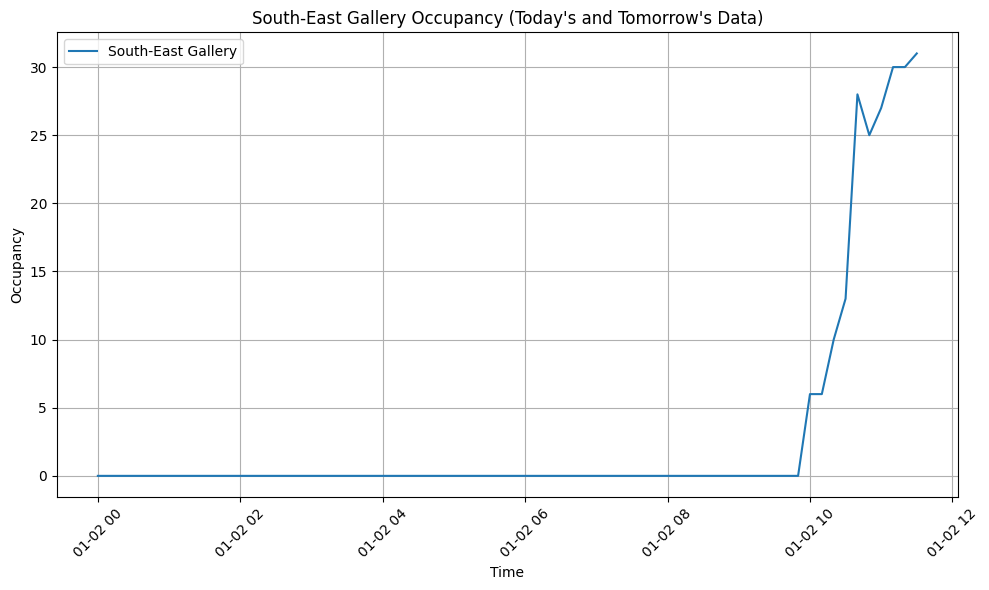

Downloaded Data (without NaN):
                     KTH Library  South-East Gallery  North Gallery  \
2025-01-02 00:00:00          0.0                 0.0            0.0   
2025-01-02 00:10:00          0.0                 0.0            0.0   
2025-01-02 00:20:00          0.0                 0.0            0.0   
2025-01-02 00:30:00          0.0                 0.0            0.0   
2025-01-02 00:40:00          0.0                 0.0            0.0   

                     South Gallery  Ångdomen  Newton  
2025-01-02 00:00:00            0.0       0.0     0.0  
2025-01-02 00:10:00            0.0       0.0     0.0  
2025-01-02 00:20:00            0.0       0.0     0.0  
2025-01-02 00:30:00            0.0       0.0     0.0  
2025-01-02 00:40:00            0.0       0.0     0.0  

Null Data (with NaN):
                     KTH Library  South-East Gallery  North Gallery  \
2025-01-02 11:40:00          NaN                 NaN            NaN   
2025-01-02 11:50:00          NaN               

In [43]:
import pandas as pd
import numpy as np
import joblib
from datasets import load_dataset
import matplotlib.pyplot as plt
from datetime import timedelta

# Step 1: Load the seating dataset
repo_name_seating = "davnas/occupancy_perc"
hf_dataset_seating = load_dataset(repo_name_seating)

# Combine all splits into a single DataFrame with appropriate data types
df_seating = pd.concat(
    [split.to_pandas().astype({'KTH Library': int, 'South-East Gallery': int, 'North Gallery': int,
                               'South Gallery': int, 'Ångdomen': int, 'Newton': int})
     for split in hf_dataset_seating.values()],
    ignore_index=True
)
df_seating.set_index('index', inplace=True)
df_seating.index = pd.to_datetime(df_seating.index)  # Ensure the index is datetime

# Resample to 10-minute intervals and fill missing data (while keeping original rounding)
df_seating_resampled = df_seating.resample('10T').mean().interpolate(method='linear').round().astype(int)

# Filter data to only include today and tomorrow
today = pd.Timestamp.today().normalize()  # Today's date without time
tomorrow_midnight = (today + timedelta(days=1)).normalize()  # Tomorrow's midnight
end_of_tomorrow = tomorrow_midnight + timedelta(days=1)  # End of tomorrow, for the full 24 hours

# Get the last available entry for today
last_valid_entry = df_seating_resampled[df_seating_resampled.index.date == today.date()].index[-1]

# Create the datetime range from the last entry until tomorrow midnight
time_range = pd.date_range(start=last_valid_entry + timedelta(minutes=10), end=end_of_tomorrow, freq='10T')

# Create a DataFrame for this time range with NaN values
nan_df = pd.DataFrame(np.nan, index=time_range, columns=df_seating_resampled.columns)

# Concatenate the original data with the NaN data (after the last valid entry until tomorrow midnight)
df_seating_combined = pd.concat([df_seating_resampled, nan_df])

# Ensure the data has the correct format, with NaN entries for after today until tomorrow midnight
df_seating_combined = df_seating_combined.sort_index()

# Filter to keep only data from today and tomorrow
df_today_tomorrow = df_seating_combined[(df_seating_combined.index >= today) & (df_seating_combined.index < end_of_tomorrow)]

# Split into downloaded data (non-NaN) and null data (NaN)
df_downloaded = df_today_tomorrow[df_today_tomorrow.notna().all(axis=1)].copy()
df_null = df_today_tomorrow[df_today_tomorrow.isna().any(axis=1)].copy()

# Recombine into the full DataFrame
df_full = pd.concat([df_downloaded, df_null]).sort_index()

# Plot the data for today and tomorrow
plt.figure(figsize=(10, 6))
plt.plot(df_full.index, df_full['South-East Gallery'], label="South-East Gallery")
plt.title("South-East Gallery Occupancy (Today's and Tomorrow's Data)")
plt.xlabel("Time")
plt.ylabel("Occupancy")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Optionally, print the split DataFrames to check
print("Downloaded Data (without NaN):")
print(df_downloaded.head())

print("\nNull Data (with NaN):")
print(df_null.head())

print("\nFull DataFrame after recombination:")
print(df_full.head())


In [44]:
df_today_tomorrow

,KTH Library,South-East Gallery,North Gallery,South Gallery,Ångdomen,Newton
2025-01-02 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0
2025-01-02 00:10:00,0.0,0.0,0.0,0.0,0.0,0.0
2025-01-02 00:20:00,0.0,0.0,0.0,0.0,0.0,0.0
2025-01-02 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0
2025-01-02 00:40:00,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
2025-01-03 23:10:00,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-03 23:20:00,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-03 23:30:00,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-03 23:40:00,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
import requests

def get_detailed_weather_forecast(latitude, longitude):
    """
    Fetches a detailed weather forecast for the remainder of the current day and the next 24 hours,
    with data points every 10 minutes created manually from hourly data.

    Parameters:
        latitude (float): Latitude of the location.
        longitude (float): Longitude of the location.

    Returns:
        pd.DataFrame: DataFrame containing the forecast data with 10-minute intervals.
    """
    url = "https://api.open-meteo.com/v1/forecast"

    params = {
        "latitude": latitude,
        "longitude": longitude,
        "hourly": ["temperature_2m", "precipitation", "wind_speed_10m", "wind_direction_10m"],
        "forecast_days": 2,  # Ensures today and tomorrow are covered
        "timezone": "auto",
    }

    response = requests.get(url, params=params)
    response.raise_for_status()
    data = response.json()

    # Extract hourly data
    hourly_data = data.get('hourly', {})

    if not hourly_data:
        raise ValueError("No hourly data available in the API response.")

    weather_df = pd.DataFrame(hourly_data)

    # Convert time to datetime format
    if "time" in weather_df.columns:
        weather_df["time"] = pd.to_datetime(weather_df["time"], errors="coerce")
    else:
        raise KeyError("The 'time' column is missing in the hourly weather data.")

    # Set 'time' as the index
    weather_df.set_index("time", inplace=True)

    # Create 10-minute intervals
    detailed_weather_data = []
    for i in range(len(weather_df) - 1):
        start_row = weather_df.iloc[i]
        end_row = weather_df.iloc[i + 1]
        time_start = weather_df.index[i]
        time_end = weather_df.index[i + 1]

        # Generate intermediate 10-minute data
        time_range = pd.date_range(time_start, time_end, periods=7)[1:]
        for t in time_range:
            interpolated_row = {
                "time": t,
                "temperature_2m": start_row["temperature_2m"] + (end_row["temperature_2m"] - start_row["temperature_2m"]) * (t - time_start) / (time_end - time_start),
                "precipitation": start_row["precipitation"] + (end_row["precipitation"] - start_row["precipitation"]) * (t - time_start) / (time_end - time_start),
                "wind_speed_10m": start_row["wind_speed_10m"] + (end_row["wind_speed_10m"] - start_row["wind_speed_10m"]) * (t - time_start) / (time_end - time_start),
                "wind_direction_10m": start_row["wind_direction_10m"] + (end_row["wind_direction_10m"] - start_row["wind_direction_10m"]) * (t - time_start) / (time_end - time_start),
            }
            detailed_weather_data.append(interpolated_row)

    # Convert to DataFrame
    detailed_weather_df = pd.DataFrame(detailed_weather_data)
    detailed_weather_df.set_index("time", inplace=True)

    # Debug outputs
    print("Index type:", detailed_weather_df.index.dtype)
    print("Columns:", detailed_weather_df.columns)

    return detailed_weather_df

# Parameters
latitude, longitude = 59.3293, 18.0686  # Stockholm coordinates

# Get weather data for today and tomorrow, interpolated to 10-minute intervals
weather_data = get_detailed_weather_forecast(latitude, longitude)

# Print the merged and interpolated weather data for today and tomorrow
weather_data



Index type: datetime64[ns]
Columns: Index(['temperature_2m', 'precipitation', 'wind_speed_10m',
       'wind_direction_10m'],
      dtype='object')


,temperature_2m,precipitation,wind_speed_10m,wind_direction_10m
time,,,,
2025-01-02 00:10:00,-2.566667,0.0,14.616667,331.500000
2025-01-02 00:20:00,-2.733333,0.0,14.133333,331.000000
2025-01-02 00:30:00,-2.900000,0.0,13.650000,330.500000
2025-01-02 00:40:00,-3.066667,0.0,13.166667,330.000000
2025-01-02 00:50:00,-3.233333,0.0,12.683333,329.500000
...,...,...,...,...
2025-01-03 22:20:00,-7.033333,0.0,14.766667,292.333333
2025-01-03 22:30:00,-7.100000,0.0,14.400000,293.000000
2025-01-03 22:40:00,-7.166667,0.0,14.033333,293.666667


In [46]:
# Step 2: Load the academic calendar dataset
repo_name_calendar = "andreitut/kth-academic-scraper"
hf_dataset_calendar = load_dataset(repo_name_calendar)

# Convert the calendar dataset to a DataFrame
df_calendar = pd.DataFrame(hf_dataset_calendar['train'])
df_calendar['Date'] = pd.to_datetime(df_calendar['Date'])

# Expand the calendar dataset to match the minute-level resolution
df_calendar_expanded = df_calendar.set_index('Date').reindex(df_seating_resampled.index.normalize(), method='ffill').reset_index()
df_calendar_expanded.rename(columns={'index': 'Date'}, inplace=True)
df_calendar_expanded

,Date,Year,Day of Year,Day of Week,Days Until Exam,Event
0,2024-12-09,2024,344,1,29,Normal
1,2024-12-09,2024,344,1,29,Normal
2,2024-12-09,2024,344,1,29,Normal
3,2024-12-09,2024,344,1,29,Normal
4,2024-12-09,2024,344,1,29,Normal
...,...,...,...,...,...,...
3412,2025-01-02,2025,2,4,5,Holyday
3413,2025-01-02,2025,2,4,5,Holyday
3414,2025-01-02,2025,2,4,5,Holyday
3415,2025-01-02,2025,2,4,5,Holyday


In [47]:
repo_name = "davnas/date_kth"

# Load the dataset from Hugging Face
hf_dataset = load_dataset(repo_name)

df_opening = pd.concat(
    [split.to_pandas() for split in hf_dataset.values()],
    ignore_index=True
)

# Set the index if the 'index' column exists
if 'index' in df_opening.columns:
    df_opening.set_index('index', inplace=True)

# Display the DataFrame
print(df_opening)


         date        day  opening_hour  closing_hour  is_open
0  2024-12-09     Monday            18            21        1
1  2024-12-10    Tuesday            10            21        1
2  2024-12-11  Wednesday             8            21        1
3  2024-12-12   Thursday             8            21        1
4  2024-12-13     Friday             8            18        1
5  2024-12-14   Saturday             0             0        0
6  2024-12-15     Sunday             0             0        0
7  2024-12-16     Monday            10            21        1
8  2024-12-17    Tuesday            10            21        1
9  2024-12-18  Wednesday             8            21        1
10 2024-12-19   Thursday             8            21        1
11 2024-12-20     Friday             8            19        1
12 2024-12-21   Saturday             0             0        0
13 2024-12-22     Sunday             0             0        0
14 2024-12-23     Monday            10            14        1
15 2024-

### 2.2 Merge the Data


In [48]:
# Step 3: Merge the seating data with the expanded academic calendar
merged_seating_calendar = pd.merge_asof(
    df_null.sort_index(),
    df_calendar_expanded.sort_values('Date'),
    left_index=True,
    right_on='Date'
)
# Visualize Step 3: Merged seating and calendar data
print("Step 3: Merged seating data with academic calendar")

merged_seating_calendar

Step 3: Merged seating data with academic calendar


,KTH Library,South-East Gallery,North Gallery,South Gallery,Ångdomen,Newton,Date,Year,Day of Year,Day of Week,Days Until Exam,Event
2025-01-02 11:40:00,NaN,NaN,NaN,NaN,NaN,NaN,2025-01-02,2025,2,4,5,Holyday
2025-01-02 11:50:00,NaN,NaN,NaN,NaN,NaN,NaN,2025-01-02,2025,2,4,5,Holyday
2025-01-02 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,2025-01-02,2025,2,4,5,Holyday
2025-01-02 12:10:00,NaN,NaN,NaN,NaN,NaN,NaN,2025-01-02,2025,2,4,5,Holyday
2025-01-02 12:20:00,NaN,NaN,NaN,NaN,NaN,NaN,2025-01-02,2025,2,4,5,Holyday
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-03 23:10:00,NaN,NaN,NaN,NaN,NaN,NaN,2025-01-02,2025,2,4,5,Holyday
2025-01-03 23:20:00,NaN,NaN,NaN,NaN,NaN,NaN,2025-01-02,2025,2,4,5,Holyday
2025-01-03 23:30:00,NaN,NaN,NaN,NaN,NaN,NaN,2025-01-02,2025,2,4,5,Holyday
2025-01-03 23:40:00,NaN,NaN,NaN,NaN,NaN,NaN,2025-01-02,2025,2,4,5,Holyday


In [49]:
# Merge historical weather data with the merged dataset
merge_seat_academic_weather = pd.merge_asof(
    merged_seating_calendar.sort_index(),
    weather_data.sort_index(),
    left_index=True,
    right_index=True,
    direction='forward'
)
merge_seat_academic_weather.drop(columns=['Date', 'Year'], inplace=True)
merge_seat_academic_weather

,KTH Library,South-East Gallery,North Gallery,South Gallery,Ångdomen,Newton,Day of Year,Day of Week,Days Until Exam,Event,temperature_2m,precipitation,wind_speed_10m,wind_direction_10m
2025-01-02 11:40:00,NaN,NaN,NaN,NaN,NaN,NaN,2,4,5,Holyday,-4.30,0.0,15.70,268.666667
2025-01-02 11:50:00,NaN,NaN,NaN,NaN,NaN,NaN,2,4,5,Holyday,-4.25,0.0,15.75,269.833333
2025-01-02 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,2,4,5,Holyday,-4.20,0.0,15.80,271.000000
2025-01-02 12:10:00,NaN,NaN,NaN,NaN,NaN,NaN,2,4,5,Holyday,-4.10,0.0,16.05,268.166667
2025-01-02 12:20:00,NaN,NaN,NaN,NaN,NaN,NaN,2,4,5,Holyday,-4.00,0.0,16.30,265.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-03 23:10:00,NaN,NaN,NaN,NaN,NaN,NaN,2,4,5,Holyday,NaN,NaN,NaN,NaN
2025-01-03 23:20:00,NaN,NaN,NaN,NaN,NaN,NaN,2,4,5,Holyday,NaN,NaN,NaN,NaN
2025-01-03 23:30:00,NaN,NaN,NaN,NaN,NaN,NaN,2,4,5,Holyday,NaN,NaN,NaN,NaN
2025-01-03 23:40:00,NaN,NaN,NaN,NaN,NaN,NaN,2,4,5,Holyday,NaN,NaN,NaN,NaN


In [50]:
# Convert the 'date' column in df_opening to datetime to match the index of merge_seat_academic_weather
df_opening['date'] = pd.to_datetime(df_opening['date'])

# Merge on the date index while ensuring time-specific data aligns properly
merged_final = pd.merge_asof(
    merge_seat_academic_weather.reset_index(),
    df_opening,
    left_on='index',
    right_on='date',
    direction='backward'
).set_index('index')

# Drop unnecessary columns if needed (like duplicate 'date' column)
merged_final.drop(columns=['date'], inplace=True)

# Display the resulting DataFrame
print(merged_final)
#merged_final.to_csv('merged_final.csv')

                     KTH Library  South-East Gallery  North Gallery  \
index                                                                 
2025-01-02 11:40:00          NaN                 NaN            NaN   
2025-01-02 11:50:00          NaN                 NaN            NaN   
2025-01-02 12:00:00          NaN                 NaN            NaN   
2025-01-02 12:10:00          NaN                 NaN            NaN   
2025-01-02 12:20:00          NaN                 NaN            NaN   
...                          ...                 ...            ...   
2025-01-03 23:10:00          NaN                 NaN            NaN   
2025-01-03 23:20:00          NaN                 NaN            NaN   
2025-01-03 23:30:00          NaN                 NaN            NaN   
2025-01-03 23:40:00          NaN                 NaN            NaN   
2025-01-03 23:50:00          NaN                 NaN            NaN   

                     South Gallery  Ångdomen  Newton  Day of Year  \
index  

### 2.3 MIT

In [51]:
df = merged_final.copy()
# Standardize the values by removing leading/trailing whitespace and converting to lowercase
df['Event'] = df['Event'].str.strip().str.lower()

# Update the mapping to match the standardized values
event_mapping = {
    'normal': 0,
    'holyday': 1,
    're-exam': 2,
    'self-study': 3
}

# Remap the 'Event' column
df['Event'] = df['Event'].map(event_mapping)

# Verify the changes
print(df['Event'].head())
df_resampled = df.copy()

index
2025-01-02 11:40:00    1
2025-01-02 11:50:00    1
2025-01-02 12:00:00    1
2025-01-02 12:10:00    1
2025-01-02 12:20:00    1
Name: Event, dtype: int64


In [52]:
# Ensure the index is a DatetimeIndex
if not isinstance(df.index, pd.DatetimeIndex):
    df.index = pd.to_datetime(df.index)

# Update 'is_open' column based on opening and closing hours
df_resampled['is_open'] = ((df_resampled.index.hour >= df_resampled['opening_hour']) & (df_resampled.index.hour < df['closing_hour'])).astype(int)
df_resampled = df_resampled[:-10]
#df_resampled.to_csv('df_resampled.csv')

In [53]:
df_future = df_resampled.copy()

### 2.4 Download Model do prediction

In [54]:
print(df_future)

                     KTH Library  South-East Gallery  North Gallery  \
index                                                                 
2025-01-02 11:40:00          NaN                 NaN            NaN   
2025-01-02 11:50:00          NaN                 NaN            NaN   
2025-01-02 12:00:00          NaN                 NaN            NaN   
2025-01-02 12:10:00          NaN                 NaN            NaN   
2025-01-02 12:20:00          NaN                 NaN            NaN   
...                          ...                 ...            ...   
2025-01-03 21:30:00          NaN                 NaN            NaN   
2025-01-03 21:40:00          NaN                 NaN            NaN   
2025-01-03 21:50:00          NaN                 NaN            NaN   
2025-01-03 22:00:00          NaN                 NaN            NaN   
2025-01-03 22:10:00          NaN                 NaN            NaN   

                     South Gallery  Ångdomen  Newton  Day of Year  \
index  

In [55]:
df_future.reset_index(inplace=True)

df_future.rename(columns={
    'index': 'ds'
}, inplace=True)


#### download the model

In [56]:

# Set your repository name
repo_name = "davnas/library_model"  # Replace with your repository name

# List of model filenames
locations = ["KTH Library", "South-East Gallery", "North Gallery", "South Gallery", "Ångdomen", "Newton"]
model_filenames = [f"prophet_model_{location.replace(' ', '_')}.joblib" for location in locations]

# Download and load each model
loaded_models = {}
for model_filename in model_filenames:
    try:
        model_path = hf_hub_download(
            repo_id=repo_name,
            filename=model_filename,
            token=HUGGINGFACE_TOKEN,          # <--- Explicitly pass the token
            use_auth_token=True,              # <--- or rely on this if set up
            force_download=True 
        )
        loaded_models[model_filename] = joblib.load(model_path)
        print(f"Model {model_filename} downloaded and loaded successfully.")
    except Exception as e:
        print(f"Failed to download or load model {model_filename}: {e}")

# Now `loaded_models` is a dictionary containing all the loaded Prophet models


/home/dave/miniconda3/envs/scrape/lib/python3.12/site-packages/huggingface_hub/utils/_validators.py:215: UserWarning: Both `token` and `use_auth_token` are passed to `hf_hub_download` with non-None values. `token` is now the preferred argument to pass a User Access Token. `use_auth_token` value will be ignored.
  warnings.warn(


prophet_model_KTH_Library.joblib:   0%|          | 0.00/646k [00:00<?, ?B/s]

Model prophet_model_KTH_Library.joblib downloaded and loaded successfully.


/home/dave/miniconda3/envs/scrape/lib/python3.12/site-packages/huggingface_hub/utils/_validators.py:215: UserWarning: Both `token` and `use_auth_token` are passed to `hf_hub_download` with non-None values. `token` is now the preferred argument to pass a User Access Token. `use_auth_token` value will be ignored.
  warnings.warn(


prophet_model_South-East_Gallery.joblib:   0%|          | 0.00/646k [00:00<?, ?B/s]

Model prophet_model_South-East_Gallery.joblib downloaded and loaded successfully.


/home/dave/miniconda3/envs/scrape/lib/python3.12/site-packages/huggingface_hub/utils/_validators.py:215: UserWarning: Both `token` and `use_auth_token` are passed to `hf_hub_download` with non-None values. `token` is now the preferred argument to pass a User Access Token. `use_auth_token` value will be ignored.
  warnings.warn(


prophet_model_North_Gallery.joblib:   0%|          | 0.00/646k [00:00<?, ?B/s]

Model prophet_model_North_Gallery.joblib downloaded and loaded successfully.


/home/dave/miniconda3/envs/scrape/lib/python3.12/site-packages/huggingface_hub/utils/_validators.py:215: UserWarning: Both `token` and `use_auth_token` are passed to `hf_hub_download` with non-None values. `token` is now the preferred argument to pass a User Access Token. `use_auth_token` value will be ignored.
  warnings.warn(


prophet_model_South_Gallery.joblib:   0%|          | 0.00/646k [00:00<?, ?B/s]

Model prophet_model_South_Gallery.joblib downloaded and loaded successfully.


/home/dave/miniconda3/envs/scrape/lib/python3.12/site-packages/huggingface_hub/utils/_validators.py:215: UserWarning: Both `token` and `use_auth_token` are passed to `hf_hub_download` with non-None values. `token` is now the preferred argument to pass a User Access Token. `use_auth_token` value will be ignored.
  warnings.warn(


prophet_model_Ãngdomen.joblib:   0%|          | 0.00/646k [00:00<?, ?B/s]

Model prophet_model_Ångdomen.joblib downloaded and loaded successfully.


/home/dave/miniconda3/envs/scrape/lib/python3.12/site-packages/huggingface_hub/utils/_validators.py:215: UserWarning: Both `token` and `use_auth_token` are passed to `hf_hub_download` with non-None values. `token` is now the preferred argument to pass a User Access Token. `use_auth_token` value will be ignored.
  warnings.warn(


prophet_model_Newton.joblib:   0%|          | 0.00/646k [00:00<?, ?B/s]

Model prophet_model_Newton.joblib downloaded and loaded successfully.


In [57]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming 'locations' is the list of rooms you want to predict for
locations = ['KTH Library','North Gallery', 'South-East Gallery', 'South Gallery', 'Ångdomen', 'Newton']
total_capacity = 100


In [58]:
df_future.columns

Index(['ds', 'KTH Library', 'South-East Gallery', 'North Gallery',
       'South Gallery', 'Ångdomen', 'Newton', 'Day of Year', 'Day of Week',
       'Days Until Exam', 'Event', 'temperature_2m', 'precipitation',
       'wind_speed_10m', 'wind_direction_10m', 'day', 'opening_hour',
       'closing_hour', 'is_open'],
      dtype='object')

In [59]:
# Create features for proximity to opening/closing times
def calculate_time_features(row):
    if row['is_open'] == 0:
        return 0, 0

    time_decimal = row['time_decimal']
    opening_hour = row['opening_hour']
    closing_hour = row['closing_hour']

    # Time since opening (in hours)
    time_since_opening = max(0, time_decimal - opening_hour)
    # Time until closing (in hours)
    time_until_closing = max(0, closing_hour - time_decimal)

    return time_since_opening, time_until_closing

In [60]:
# Dictionary to store predictions for all locations
predictions_dict = {}

# Iterate through each location
for location in locations:
    # Ensure the model for this location is available
    model_key = f"prophet_model_{location.replace(' ', '_')}.joblib"
    if model_key not in loaded_models:
        print(f"Model for {location} not found. Skipping...")
        continue

    # Ensure the location column exists in df_future
    if location in df_future.columns:
        # Filter the data for the current location
        df_location = df_future[['ds', location, 'Day of Year', 'Day of Week', 'Days Until Exam', 'is_open',
                                 'opening_hour', 'closing_hour', 'temperature_2m', 'precipitation', 'wind_speed_10m']].copy()

        # Rename columns for compatibility
        df_location.rename(columns={
            location: 'y',
            'Day of Year': 'DayOfYear',
            'Day of Week': 'DayOfWeek',
            'Days Until Exam': 'DaysUntilExam'
        }, inplace=True)

        # Add time-based features
        df_location['hour'] = df_location['ds'].dt.hour
        df_location['minute'] = df_location['ds'].dt.minute
        df_location['time_decimal'] = df_location['hour'] + df_location['minute'] / 60

        # Add new time-based features for proximity to opening/closing times
        df_location[['time_since_opening', 'time_until_closing']] = df_location.apply(
            calculate_time_features, axis=1, result_type='expand'
        )

        # Prepare the future dataframe for predictions
        future_location = df_location[['ds']].copy()
        future_location['cap'] = total_capacity
        future_location['floor'] = 0

        # Add time-based features to the future DataFrame
        future_location['hour'] = future_location['ds'].dt.hour
        future_location['minute'] = future_location['ds'].dt.minute
        future_location['time_decimal'] = future_location['hour'] + future_location['minute'] / 60

        # Add all regressors from the test set
        for regressor in ['DayOfYear', 'DayOfWeek', 'DaysUntilExam', 'temperature_2m',
                          'precipitation', 'wind_speed_10m', 'is_open', 'opening_hour', 'closing_hour']:
            future_location[regressor] = df_location[regressor]

        # Calculate time features for future data
        future_location[['time_since_opening', 'time_until_closing']] = future_location.apply(
            calculate_time_features, axis=1, result_type='expand'
        )

        # Use the loaded model for predictions
        loaded_model = loaded_models[model_key]
        forecast_location = loaded_model.predict(future_location)

        # Apply strict rules for opening/closing times
        forecast_location['yhat'] = np.where(future_location['is_open'] == 0, 0,
                                             np.where(future_location['time_since_opening'] == 0, 0,
                                             np.where(future_location['time_until_closing'] == 0, 0,
                                             np.clip(forecast_location['yhat'], 0, 100))))

        forecast_location['yhat_lower'] = np.where(future_location['is_open'] == 0, 0,
                                                   np.where(future_location['time_since_opening'] == 0, 0,
                                                   np.where(future_location['time_until_closing'] == 0, 0,
                                                   np.clip(forecast_location['yhat_lower'], 0, 100))))

        forecast_location['yhat_upper'] = np.where(future_location['is_open'] == 0, 0,
                                                   np.where(future_location['time_since_opening'] == 0, 0,
                                                   np.where(future_location['time_until_closing'] == 0, 0,
                                                   np.clip(forecast_location['yhat_upper'], 0, 100))))

        # Store the forecast for the current location
        predictions_dict[location] = forecast_location
    else:
        print(f"Location column '{location}' not found in the data.")


In [61]:
# Now, predictions_dict contains the predictions for all locations
# Example: Access predictions for KTH Library
# After the predictions_dict is populated
print("Predictions dict keys:")
print(list(predictions_dict.keys()))

# Example of accessing a specific prediction
if "KTH Library" in predictions_dict:
    forecast_KTH_Library = predictions_dict["KTH Library"]
    print("Forecast for KTH Library loaded successfully.")
else:
    print("KTH Library forecast not found in predictions_dict.")


Predictions dict keys:
['KTH Library', 'North Gallery', 'South-East Gallery', 'South Gallery', 'Ångdomen', 'Newton']
Forecast for KTH Library loaded successfully.


In [62]:
# Initialize an empty DataFrame to hold the combined data
combined_predictions = pd.DataFrame()

# Iterate through each location and add its predictions to the combined DataFrame
for location, forecast_df in predictions_dict.items():
    # Extract the `ds` and `yhat` columns and rename `yhat` to the location name
    location_forecast = forecast_df[['ds', 'yhat']].copy()
    location_forecast.rename(columns={'yhat': location}, inplace=True)

    # Convert predictions to integers
    location_forecast[location] = location_forecast[location].astype(int)

    # Merge this location's predictions with the combined DataFrame
    if combined_predictions.empty:
        combined_predictions = location_forecast
    else:
        combined_predictions = pd.merge(combined_predictions, location_forecast, on='ds')

# Display the final combined DataFrame
combined_predictions.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   ds                  208 non-null    datetime64[ns]
 1   KTH Library         208 non-null    int64         
 2   North Gallery       208 non-null    int64         
 3   South-East Gallery  208 non-null    int64         
 4   South Gallery       208 non-null    int64         
 5   Ångdomen            208 non-null    int64         
 6   Newton              208 non-null    int64         
dtypes: datetime64[ns](1), int64(6)
memory usage: 11.5 KB


## 2.5 Combining the past and future

In [63]:
df_past = df_downloaded.copy()
df_past.reset_index(inplace=True)
df_past.rename(columns={
    'index': 'ds'
}, inplace=True)
df_past['prediction'] = 0

df_past

,ds,KTH Library,South-East Gallery,North Gallery,South Gallery,Ångdomen,Newton,prediction
0,2025-01-02 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0
1,2025-01-02 00:10:00,0.0,0.0,0.0,0.0,0.0,0.0,0
2,2025-01-02 00:20:00,0.0,0.0,0.0,0.0,0.0,0.0,0
3,2025-01-02 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0
4,2025-01-02 00:40:00,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...
65,2025-01-02 10:50:00,16.0,25.0,29.0,6.0,7.0,17.0,0
66,2025-01-02 11:00:00,18.0,27.0,31.0,8.0,8.0,28.0,0
67,2025-01-02 11:10:00,20.0,30.0,31.0,10.0,8.0,28.0,0
68,2025-01-02 11:20:00,19.0,30.0,34.0,9.0,8.0,19.0,0


In [64]:
df_future = combined_predictions.copy()
df_future['prediction'] = 1
df_future

,ds,KTH Library,North Gallery,South-East Gallery,South Gallery,Ångdomen,Newton,prediction
0,2025-01-02 11:40:00,0,0,0,0,0,0,1
1,2025-01-02 11:50:00,0,0,0,0,0,0,1
2,2025-01-02 12:00:00,0,0,0,0,0,0,1
3,2025-01-02 12:10:00,0,0,0,0,0,0,1
4,2025-01-02 12:20:00,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...
203,2025-01-03 21:30:00,0,0,0,0,0,0,1
204,2025-01-03 21:40:00,0,0,0,0,0,0,1
205,2025-01-03 21:50:00,0,0,0,0,0,0,1
206,2025-01-03 22:00:00,0,0,0,0,0,0,1


In [65]:
df_full = pd.concat([df_past, df_future])
df_full

,ds,KTH Library,South-East Gallery,North Gallery,South Gallery,Ångdomen,Newton,prediction
0,2025-01-02 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0
1,2025-01-02 00:10:00,0.0,0.0,0.0,0.0,0.0,0.0,0
2,2025-01-02 00:20:00,0.0,0.0,0.0,0.0,0.0,0.0,0
3,2025-01-02 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0
4,2025-01-02 00:40:00,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...
203,2025-01-03 21:30:00,0.0,0.0,0.0,0.0,0.0,0.0,1
204,2025-01-03 21:40:00,0.0,0.0,0.0,0.0,0.0,0.0,1
205,2025-01-03 21:50:00,0.0,0.0,0.0,0.0,0.0,0.0,1
206,2025-01-03 22:00:00,0.0,0.0,0.0,0.0,0.0,0.0,1


## 2.6 Plotting 

In [66]:
from datetime import datetime

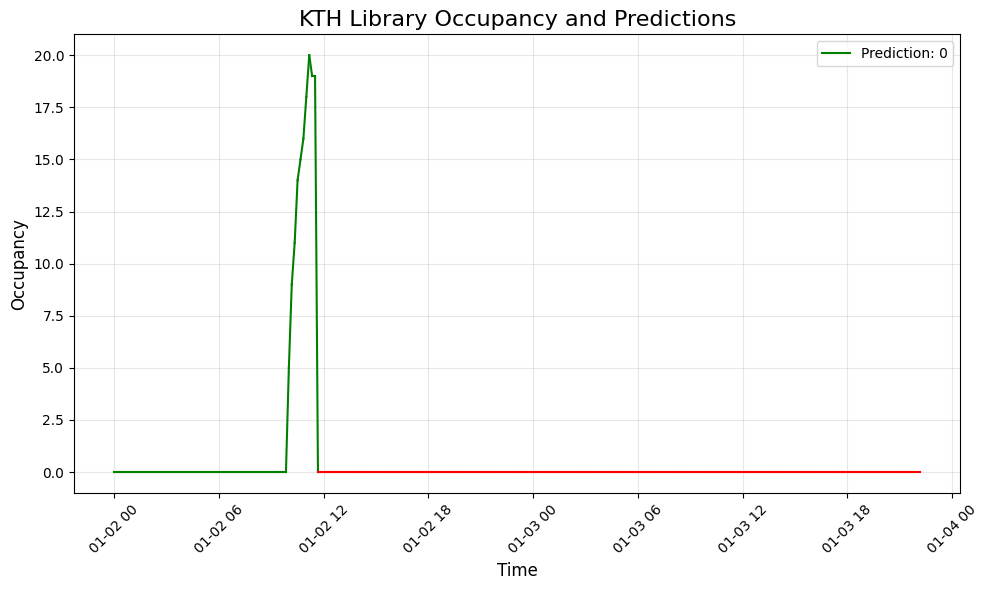

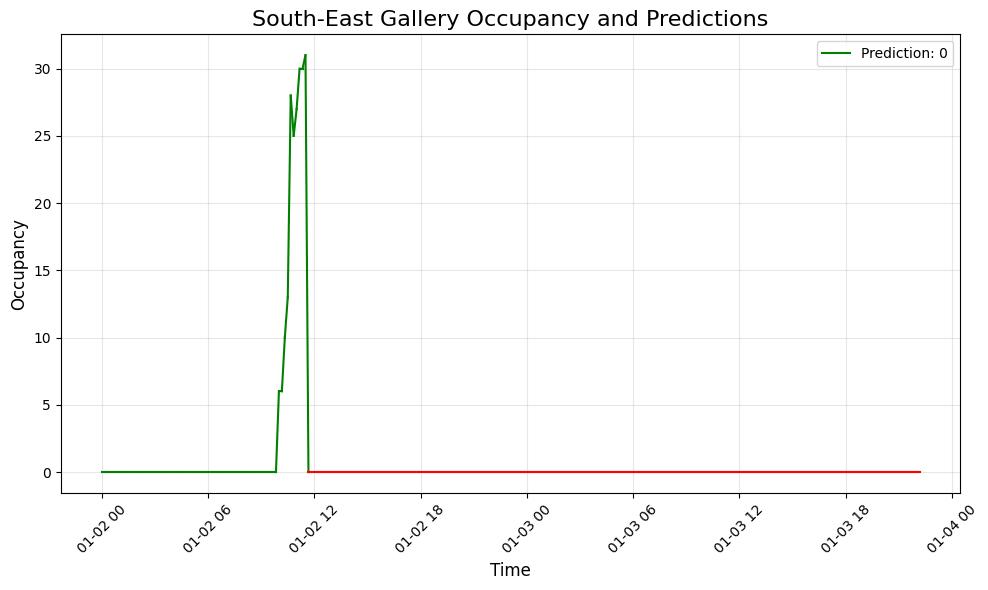

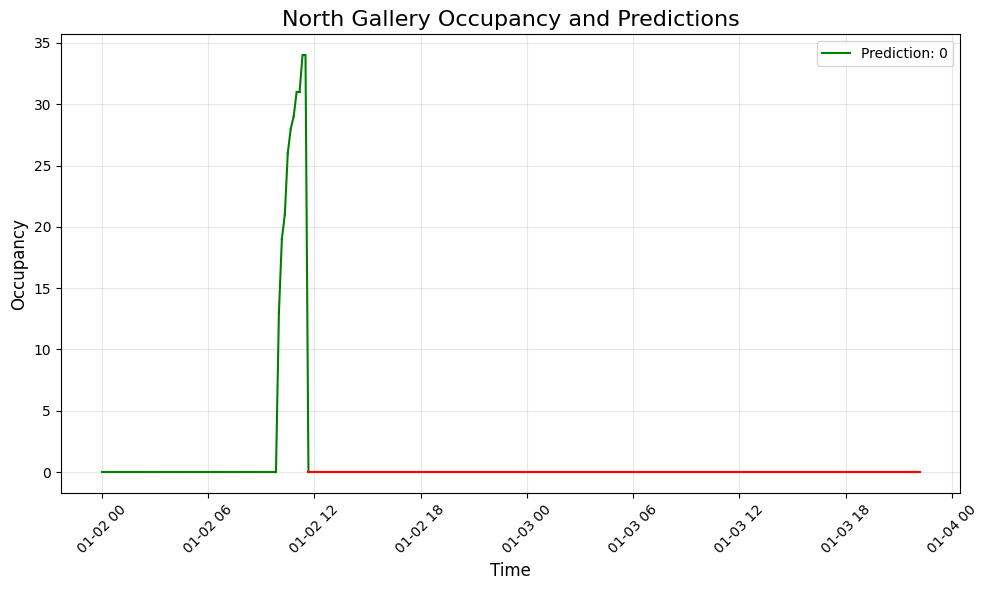

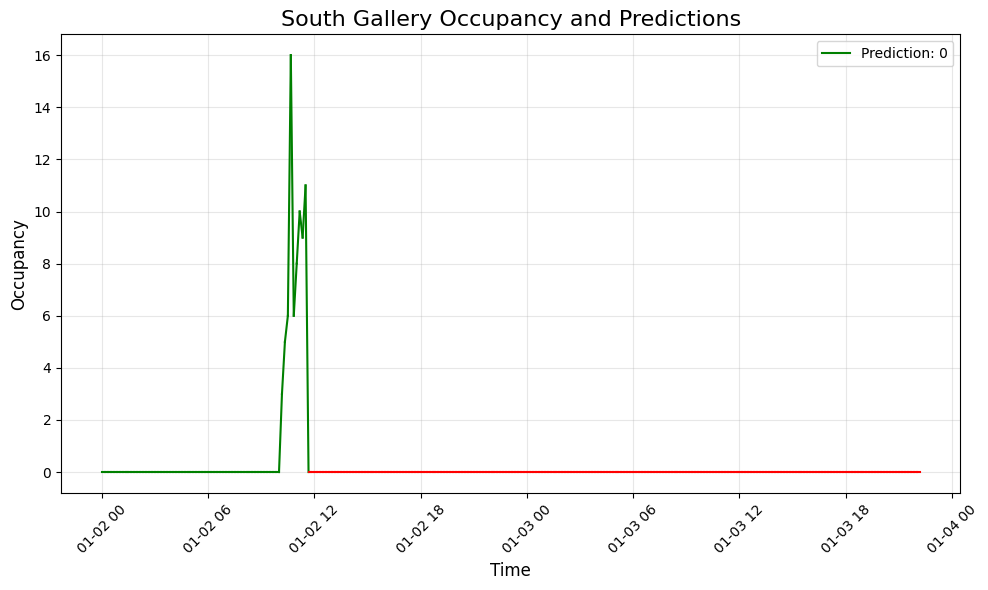

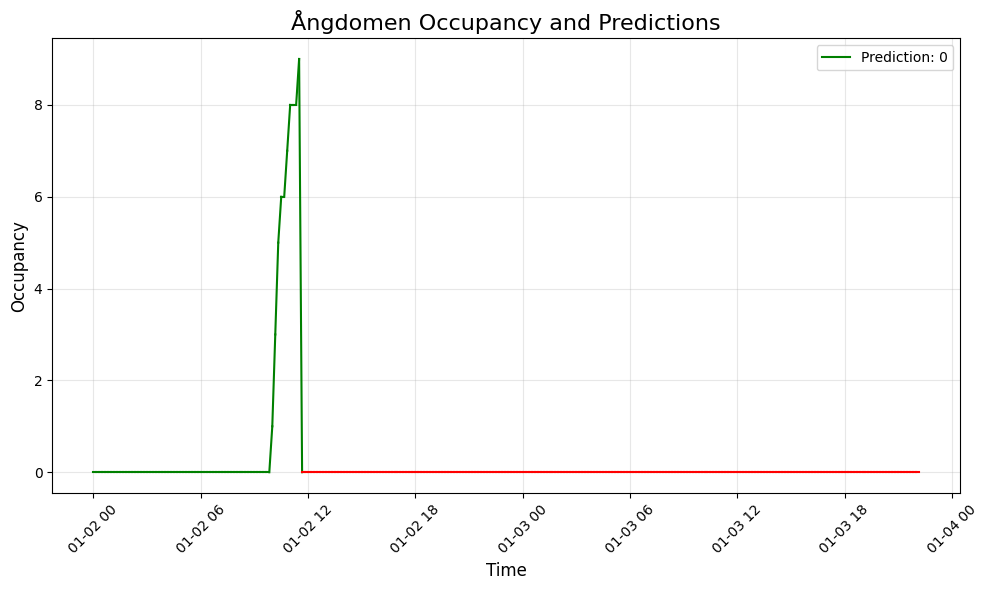

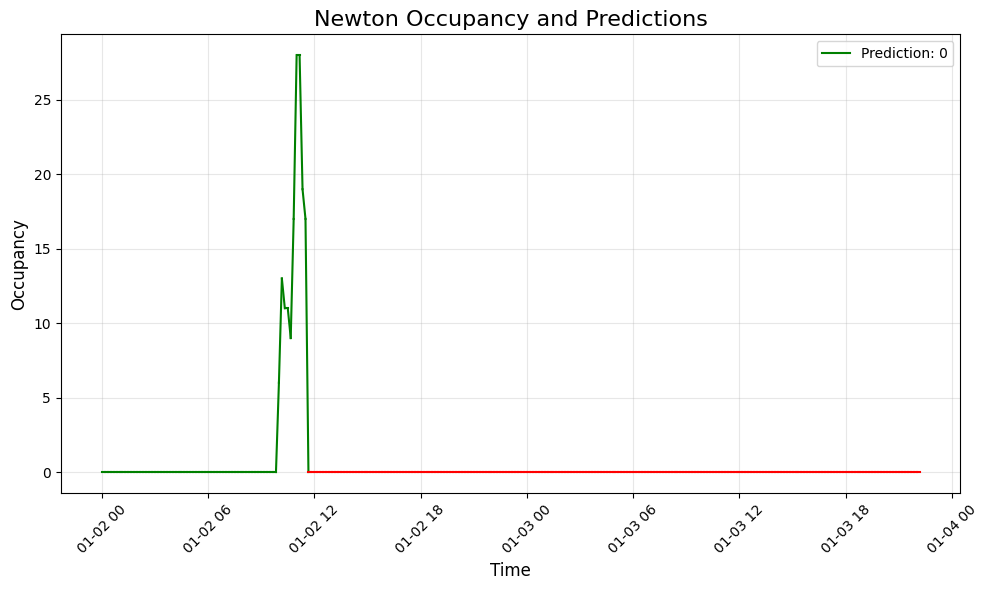

In [67]:
# Ensure the 'ds' column exists and is datetime
if 'ds' not in df_full.columns:
    raise KeyError("'ds' column is missing from the DataFrame.")

# Plot each location in a separate figure
locations = ['KTH Library', 'South-East Gallery', 'North Gallery', 'South Gallery', 'Ångdomen', 'Newton']

for location in locations:
    plt.figure(figsize=(10, 6))

    # Iterate through the DataFrame rows and plot segments based on prediction
    for i in range(len(df_full) - 1):
        color = 'green' if df_full['prediction'].iloc[i] == 0 else 'red'
        plt.plot(
            df_full['ds'].iloc[i:i+2],  # X-axis
            df_full[location].iloc[i:i+2],  # Y-axis
            color=color, label=f'Prediction: {df_full["prediction"].iloc[i]}' if i == 0 else ""
        )

    plt.title(f"{location} Occupancy and Predictions", fontsize=16)
    plt.xlabel("Time", fontsize=12)
    plt.ylabel("Occupancy", fontsize=12)
    plt.legend(loc="upper right")
    plt.xticks(rotation=45)
    plt.grid(alpha=0.3)
    plt.tight_layout()

    # Show each plot
    plt.show()

## 2.7 Pushing:

In [68]:
import pandas as pd
from datetime import timedelta

# Ensure 'ds' is localized correctly
if df_full['ds'].dt.tz is None:
    df_full['ds'] = df_full['ds'].dt.tz_localize('UTC')  # Localize as UTC

# Remove timezone if you want naive timestamps
df_full['ds'] = df_full['ds'].dt.tz_convert(None)


                    ds  KTH Library  South-East Gallery  North Gallery  \
24 2025-01-02 19:30:00          0.0                 0.0            0.0   
25 2025-01-02 20:00:00          0.0                 0.0            0.0   
26 2025-01-02 20:30:00          0.0                 0.0            0.0   
27 2025-01-02 21:00:00          0.0                 0.0            0.0   
28 2025-01-02 21:30:00          0.0                 0.0            0.0   

    South Gallery  Ångdomen  Newton  prediction  
24            0.0       0.0     0.0         1.0  
25            0.0       0.0     0.0         1.0  
26            0.0       0.0     0.0         1.0  
27            0.0       0.0     0.0         1.0  
28            0.0       0.0     0.0         1.0  


In [ ]:
# Get today's normalized date
today_date = pd.Timestamp.now().normalize()

# Filter for today's data
df_today = df_full[(df_full['ds'] >= today_date) & (df_full['ds'] < today_date + timedelta(days=1))]

# Resample as needed
df_today_resampled = (
    df_today.set_index('ds')
    .resample('30T')
    .mean()
    .reset_index()
)

# Define time range
start_time = today_date + timedelta(hours=7, minutes=30)
end_time = today_date + timedelta(hours=21, minutes=30)

# Reindex to fill gaps
time_range = pd.date_range(start=start_time, end=end_time, freq='30T')
df_today_resampled = (
    df_today_resampled
    .set_index('ds')
    .reindex(time_range)
    .reset_index()
    .rename(columns={'index': 'ds'})
)

df_today_resampled

                    ds  KTH Library  South-East Gallery  North Gallery  \
24 2025-01-03 19:30:00          0.0                 0.0            0.0   
25 2025-01-03 20:00:00          0.0                 0.0            0.0   
26 2025-01-03 20:30:00          0.0                 0.0            0.0   
27 2025-01-03 21:00:00          0.0                 0.0            0.0   
28 2025-01-03 21:30:00          0.0                 0.0            0.0   

    South Gallery  Ångdomen  Newton  prediction  
24            0.0       0.0     0.0         1.0  
25            0.0       0.0     0.0         1.0  
26            0.0       0.0     0.0         1.0  
27            0.0       0.0     0.0         1.0  
28            0.0       0.0     0.0         1.0  


In [ ]:
# Get tomorrow's normalized date
tomorrow_date = (pd.Timestamp.now() + timedelta(days=1)).normalize()

# Filter for tomorrow's data
df_tomorrow = df_full[(df_full['ds'] >= tomorrow_date) & (df_full['ds'] < tomorrow_date + timedelta(days=1))]

# Resample as needed
df_tomorrow_resampled = (
    df_tomorrow.set_index('ds')
    .resample('30T')
    .mean()
    .reset_index()
)

# Define time range
start_time = tomorrow_date + timedelta(hours=7, minutes=30)
end_time = tomorrow_date + timedelta(hours=21, minutes=30)

# Reindex to fill gaps
time_range = pd.date_range(start=start_time, end=end_time, freq='30T')
df_tomorrow_resampled = (
    df_tomorrow_resampled
    .set_index('ds')
    .reindex(time_range)
    .reset_index()
    .rename(columns={'index': 'ds'})
)

df_tomorrow_resampled

In [70]:
# Convert all occupancy values to integers
occupancy_columns = ['KTH Library', 'South-East Gallery', 'North Gallery', 'South Gallery', 'Ångdomen', 'Newton']
df_today_resampled[occupancy_columns] = df_today_resampled[occupancy_columns].fillna(0).astype(int)
df_tomorrow_resampled[occupancy_columns] = df_tomorrow_resampled[occupancy_columns].fillna(0).astype(int)

In [71]:
# Add the required columns for CommitTime and Time
current_time = datetime.now()

commit_time = (current_time + timedelta(hours=1)).strftime("%Y-%m-%d %H:%M:%S")
df_today_resampled['CommitTime'] = commit_time
df_tomorrow_resampled['CommitTime'] = commit_time

df_today_resampled['Time'] = df_today_resampled['ds'].dt.strftime('%H:%M')
df_tomorrow_resampled['Time'] = df_tomorrow_resampled['ds'].dt.strftime('%H:%M')

# Rename columns to match the required format
df_today_resampled = df_today_resampled.rename(columns={
    'KTH Library': 'Occupancy_main',
    'South-East Gallery': 'Occupancy_southEast',
    'North Gallery': 'Occupancy_north',
    'South Gallery': 'Occupancy_south',
    'Ångdomen': 'Occupancy_angdomen',
    'Newton': 'Occupancy_newton'
})

df_tomorrow_resampled = df_tomorrow_resampled.rename(columns={
    'KTH Library': 'Occupancy_main',
    'South-East Gallery': 'Occupancy_southEast',
    'North Gallery': 'Occupancy_north',
    'South Gallery': 'Occupancy_south',
    'Ångdomen': 'Occupancy_angdomen',
    'Newton': 'Occupancy_newton'
})

# Reorder columns
df_today_resampled = df_today_resampled[
    ['CommitTime', 'Time', 'Occupancy_main', 'Occupancy_southEast', 'Occupancy_north',
     'Occupancy_south', 'Occupancy_angdomen', 'Occupancy_newton']
]

df_tomorrow_resampled = df_tomorrow_resampled[
    ['CommitTime', 'Time', 'Occupancy_main', 'Occupancy_southEast', 'Occupancy_north',
     'Occupancy_south', 'Occupancy_angdomen', 'Occupancy_newton']
]


In [72]:
# Save to CSV
df_tomorrow_resampled.to_csv('tomorrow_resampled.csv', index=False)

# Display the first few rows of the DataFrame
print(df_today_resampled.tail())

             CommitTime   Time  Occupancy_main  Occupancy_southEast  \
24  2025-01-02 12:54:22  19:30               0                    0   
25  2025-01-02 12:54:22  20:00               0                    0   
26  2025-01-02 12:54:22  20:30               0                    0   
27  2025-01-02 12:54:22  21:00               0                    0   
28  2025-01-02 12:54:22  21:30               0                    0   

    Occupancy_north  Occupancy_south  Occupancy_angdomen  Occupancy_newton  
24                0                0                   0                 0  
25                0                0                   0                 0  
26                0                0                   0                 0  
27                0                0                   0                 0  
28                0                0                   0                 0  


In [73]:
# Save to CSV
df_today_resampled.to_csv('occupancy_today.csv', index=False)

# Display the first few rows of the DataFrame
print(df_today_resampled.tail())

             CommitTime   Time  Occupancy_main  Occupancy_southEast  \
24  2025-01-02 12:54:22  19:30               0                    0   
25  2025-01-02 12:54:22  20:00               0                    0   
26  2025-01-02 12:54:22  20:30               0                    0   
27  2025-01-02 12:54:22  21:00               0                    0   
28  2025-01-02 12:54:22  21:30               0                    0   

    Occupancy_north  Occupancy_south  Occupancy_angdomen  Occupancy_newton  
24                0                0                   0                 0  
25                0                0                   0                 0  
26                0                0                   0                 0  
27                0                0                   0                 0  
28                0                0                   0                 0  


In [ ]:
import pandas as pd


csv_file_path = "occupancy_today.csv"
csv_file_path_1 = "tomorrow_resampled.csv"

from huggingface_hub import HfApi, HfFolder

# Hugging Face token and repository details
repo_name = "davnas/library-occupancy"  # Replace with your repository name
#csv_file_path = "data.csv"  # Replace with your CSV file path

# Authenticate using the token
HfFolder.save_token(HUGGINGFACE_TOKEN)
api = HfApi()

# Upload the CSV file
api.upload_file(
    path_or_fileobj=csv_file_path,
    path_in_repo="data_2.csv",  # The name of the file in the repository
    repo_id=repo_name,
    repo_type="dataset",  # Indicates this is a dataset repository
    token=HUGGINGFACE_TOKEN
)

api.upload_file(
    path_or_fileobj=csv_file_path_1,
    path_in_repo="forecast_tomorrow.csv",  # The name of the file in the repository
    repo_id=repo_name,
    repo_type="dataset",  # Indicates this is a dataset repository
    token=HUGGINGFACE_TOKEN
)

print(f"CSV file successfully uploaded to Hugging Face repository: {repo_name}")



CSV file successfully uploaded to Hugging Face repository: davnas/library-occupancy
